# LESSON 4: SPEECH RECOGNITION INTRODUCTION
<img src="../images/audio_intro.png" width="300px"/>

## 1. Overall introduction


## 2. Image processing
### 2.1. Digital image

### 2.2. Task in image processing

## 3. Convolution neural network (CNN)
### 3.1. Overall architecture

### 3.2. Convolution layer
#### Convolution operator

#### Stride

#### Padding

### 3.3. Pooling layer

#### Max pooling and Average pooling

#### Adaptive pooling (RoI pooling)

## 4. Popular CNN architecture
### 4.1. VGG architecture

### 4.2. ResNet architecture


### 4.3. EfficientNet architecture

## 5. Simple implementation
### 5.1. Problem

### 5.2. Solution
``` bash
conda install -c conda-forge librosa -y
```

In [1]:
import os

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.metrics import CategoricalAccuracy
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation

import IPython.display as ipd  # To play sound in the notebook

#### Prepare data
In the dataset, file name contains label: <br>
- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise'

In [2]:
data_path = '../data/speech_emotion_dataset'

In [3]:
items = os.listdir(data_path)

In [4]:
item_paths, emotions = [], []

for item in items:
    item_paths.append(os.path.join(data_path, item))
    if item[-8:-6]=='_a':
        emotions.append('angry')
    elif item[-8:-6]=='_d':
        emotions.append('disgust')
    elif item[-8:-6]=='_f':
        emotions.append('fear')
    elif item[-8:-6]=='_h':
        emotions.append('happy')
    elif item[-8:-6]=='_n':
        emotions.append('neutral')
    elif item[-8:-6]=='sa':
        emotions.append('sad')
    elif item[-8:-6]=='su':
        emotions.append('surprise')
    else:
        emotions.append('male_error')

In [5]:
len(item_paths), len(emotions)

(480, 480)

In [6]:
df = pd.DataFrame(data={
    'path': item_paths,
    'label': emotions
})
df

,path,label
0,../data/speech_emotion_dataset/JK_sa01.wav,sad
1,../data/speech_emotion_dataset/JK_sa15.wav,sad
2,../data/speech_emotion_dataset/DC_n13.wav,neutral
3,../data/speech_emotion_dataset/DC_su09.wav,surprise
4,../data/speech_emotion_dataset/DC_n07.wav,neutral
...,...,...
475,../data/speech_emotion_dataset/JE_a01.wav,angry
476,../data/speech_emotion_dataset/JE_a15.wav,angry
477,../data/speech_emotion_dataset/DC_n22.wav,neutral
478,../data/speech_emotion_dataset/DC_su04.wav,surprise


In [7]:
df.label.value_counts()

neutral     120
disgust      60
sad          60
happy        60
fear         60
surprise     60
angry        60
Name: label, dtype: int64

#### Visualize data

In [8]:
audio_data, sampling_rate = librosa.load(item_paths[0])
emotions[0]

'sad'

In [9]:
audio_data

array([0.03024001, 0.04436965, 0.03918964, ..., 0.04033332, 0.0392058 ,
       0.04239963], dtype=float32)

In [10]:
audio_data.shape

(99486,)

In [11]:
sampling_rate

22050

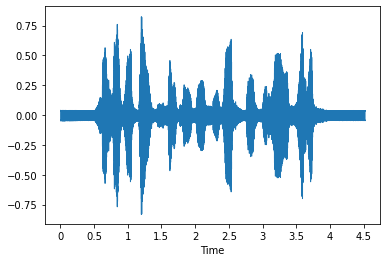

In [12]:
librosa.display.waveshow(audio_data, sr=sampling_rate)
plt.show()

In [13]:
ipd.Audio(item_paths[0])

#### Extract features
MFCC quick intro 

In [14]:
mfcc = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=13)
mfcc.shape

(13, 195)

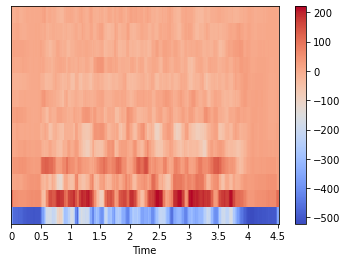

In [15]:
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.show()

In [16]:
def prepare_features(path):
    data, sampling_rate = librosa.load(path)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    return mfcc

In [17]:
df['features'] = df.path.apply(prepare_features)
df

,path,label,features
0,../data/speech_emotion_dataset/JK_sa01.wav,sad,"[-9.654484, -13.693242, -25.06487, -25.188475,..."
1,../data/speech_emotion_dataset/JK_sa15.wav,sad,"[-10.097382, -14.291897, -24.644548, -25.09320..."
2,../data/speech_emotion_dataset/DC_n13.wav,neutral,"[-9.939091, -14.169129, -25.157728, -25.081776..."
3,../data/speech_emotion_dataset/DC_su09.wav,surprise,"[-9.853862, -13.971773, -25.05912, -24.871264,..."
4,../data/speech_emotion_dataset/DC_n07.wav,neutral,"[-10.053208, -14.191269, -24.676859, -25.94601..."
...,...,...,...
475,../data/speech_emotion_dataset/JE_a01.wav,angry,"[-7.7822747, -11.702844, -22.761024, -23.81133..."
476,../data/speech_emotion_dataset/JE_a15.wav,angry,"[-15.938935, -18.806816, -23.183683, -23.40849..."
477,../data/speech_emotion_dataset/DC_n22.wav,neutral,"[-10.19491, -14.431625, -24.7342, -25.550598, ..."
478,../data/speech_emotion_dataset/DC_su04.wav,surprise,"[-10.015773, -13.8800745, -23.818092, -25.5333..."


In [18]:
df = pd.concat([df, pd.DataFrame(df['features'].values.tolist())], axis=1)
df

,path,label,features,0,1,2,3,4,5,6,...,298,299,300,301,302,303,304,305,306,307
0,../data/speech_emotion_dataset/JK_sa01.wav,sad,"[-9.654484, -13.693242, -25.06487, -25.188475,...",-9.654484,-13.693242,-25.064871,-25.188475,-23.445303,-23.593538,-24.573729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,../data/speech_emotion_dataset/JK_sa15.wav,sad,"[-10.097382, -14.291897, -24.644548, -25.09320...",-10.097382,-14.291897,-24.644548,-25.093203,-24.563478,-24.734585,-24.898933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,../data/speech_emotion_dataset/DC_n13.wav,neutral,"[-9.939091, -14.169129, -25.157728, -25.081776...",-9.939091,-14.169129,-25.157728,-25.081776,-25.676418,-26.824949,-25.405260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,../data/speech_emotion_dataset/DC_su09.wav,surprise,"[-9.853862, -13.971773, -25.05912, -24.871264,...",-9.853862,-13.971773,-25.059120,-24.871264,-24.500002,-24.954672,-25.001652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,../data/speech_emotion_dataset/DC_n07.wav,neutral,"[-10.053208, -14.191269, -24.676859, -25.94601...",-10.053208,-14.191269,-24.676859,-25.946014,-24.369246,-25.589382,-25.531221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,../data/speech_emotion_dataset/JE_a01.wav,angry,"[-7.7822747, -11.702844, -22.761024, -23.81133...",-7.782275,-11.702844,-22.761024,-23.811331,-23.213886,-22.851021,-22.649828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,../data/speech_emotion_dataset/JE_a15.wav,angry,"[-15.938935, -18.806816, -23.183683, -23.40849...",-15.938935,-18.806816,-23.183683,-23.408495,-23.577431,-24.779213,-25.357958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,../data/speech_emotion_dataset/DC_n22.wav,neutral,"[-10.19491, -14.431625, -24.7342, -25.550598, ...",-10.194910,-14.431625,-24.734200,-25.550598,-24.839703,-25.293497,-25.942904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,../data/speech_emotion_dataset/DC_su04.wav,surprise,"[-10.015773, -13.8800745, -23.818092, -25.5333...",-10.015773,-13.880075,-23.818092,-25.533386,-25.023247,-23.909716,-24.045549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df = df.fillna(0)
df

,path,label,features,0,1,2,3,4,5,6,...,298,299,300,301,302,303,304,305,306,307
0,../data/speech_emotion_dataset/JK_sa01.wav,sad,"[-9.654484, -13.693242, -25.06487, -25.188475,...",-9.654484,-13.693242,-25.064871,-25.188475,-23.445303,-23.593538,-24.573729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../data/speech_emotion_dataset/JK_sa15.wav,sad,"[-10.097382, -14.291897, -24.644548, -25.09320...",-10.097382,-14.291897,-24.644548,-25.093203,-24.563478,-24.734585,-24.898933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,../data/speech_emotion_dataset/DC_n13.wav,neutral,"[-9.939091, -14.169129, -25.157728, -25.081776...",-9.939091,-14.169129,-25.157728,-25.081776,-25.676418,-26.824949,-25.405260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,../data/speech_emotion_dataset/DC_su09.wav,surprise,"[-9.853862, -13.971773, -25.05912, -24.871264,...",-9.853862,-13.971773,-25.059120,-24.871264,-24.500002,-24.954672,-25.001652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,../data/speech_emotion_dataset/DC_n07.wav,neutral,"[-10.053208, -14.191269, -24.676859, -25.94601...",-10.053208,-14.191269,-24.676859,-25.946014,-24.369246,-25.589382,-25.531221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,../data/speech_emotion_dataset/JE_a01.wav,angry,"[-7.7822747, -11.702844, -22.761024, -23.81133...",-7.782275,-11.702844,-22.761024,-23.811331,-23.213886,-22.851021,-22.649828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,../data/speech_emotion_dataset/JE_a15.wav,angry,"[-15.938935, -18.806816, -23.183683, -23.40849...",-15.938935,-18.806816,-23.183683,-23.408495,-23.577431,-24.779213,-25.357958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,../data/speech_emotion_dataset/DC_n22.wav,neutral,"[-10.19491, -14.431625, -24.7342, -25.550598, ...",-10.194910,-14.431625,-24.734200,-25.550598,-24.839703,-25.293497,-25.942904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,../data/speech_emotion_dataset/DC_su04.wav,surprise,"[-10.015773, -13.8800745, -23.818092, -25.5333...",-10.015773,-13.880075,-23.818092,-25.533386,-25.023247,-23.909716,-24.045549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Prepare config

In [20]:
# Data config
train_val_split_rate = 0.8
train_batch_size = 512
val_batch_size = 512
shuffle_train_set = True

# Model config
# conv_filters_list = [16, 32, 64, 128, 256]

# Training config
lr = 1e-3
lr_factor = 0.1
lr_patience = 2
lr_min = 1e-10
n_epoch = 100
folder_path = 'audio_example'

#### Split data into train set and val set

In [21]:
df

,path,label,features,0,1,2,3,4,5,6,...,298,299,300,301,302,303,304,305,306,307
0,../data/speech_emotion_dataset/JK_sa01.wav,sad,"[-9.654484, -13.693242, -25.06487, -25.188475,...",-9.654484,-13.693242,-25.064871,-25.188475,-23.445303,-23.593538,-24.573729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../data/speech_emotion_dataset/JK_sa15.wav,sad,"[-10.097382, -14.291897, -24.644548, -25.09320...",-10.097382,-14.291897,-24.644548,-25.093203,-24.563478,-24.734585,-24.898933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,../data/speech_emotion_dataset/DC_n13.wav,neutral,"[-9.939091, -14.169129, -25.157728, -25.081776...",-9.939091,-14.169129,-25.157728,-25.081776,-25.676418,-26.824949,-25.405260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,../data/speech_emotion_dataset/DC_su09.wav,surprise,"[-9.853862, -13.971773, -25.05912, -24.871264,...",-9.853862,-13.971773,-25.059120,-24.871264,-24.500002,-24.954672,-25.001652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,../data/speech_emotion_dataset/DC_n07.wav,neutral,"[-10.053208, -14.191269, -24.676859, -25.94601...",-10.053208,-14.191269,-24.676859,-25.946014,-24.369246,-25.589382,-25.531221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,../data/speech_emotion_dataset/JE_a01.wav,angry,"[-7.7822747, -11.702844, -22.761024, -23.81133...",-7.782275,-11.702844,-22.761024,-23.811331,-23.213886,-22.851021,-22.649828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,../data/speech_emotion_dataset/JE_a15.wav,angry,"[-15.938935, -18.806816, -23.183683, -23.40849...",-15.938935,-18.806816,-23.183683,-23.408495,-23.577431,-24.779213,-25.357958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,../data/speech_emotion_dataset/DC_n22.wav,neutral,"[-10.19491, -14.431625, -24.7342, -25.550598, ...",-10.194910,-14.431625,-24.734200,-25.550598,-24.839703,-25.293497,-25.942904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,../data/speech_emotion_dataset/DC_su04.wav,surprise,"[-10.015773, -13.8800745, -23.818092, -25.5333...",-10.015773,-13.880075,-23.818092,-25.533386,-25.023247,-23.909716,-24.045549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
shuffle_df = df.sample(frac=1, random_state=1)

In [23]:
shuffle_df

,path,label,features,0,1,2,3,4,5,6,...,298,299,300,301,302,303,304,305,306,307
293,../data/speech_emotion_dataset/DC_a11.wav,angry,"[-7.9970326, -12.03243, -24.247377, -24.297962...",-7.997033,-12.032430,-24.247377,-24.297962,-23.375216,-23.695112,-23.596384,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
283,../data/speech_emotion_dataset/JE_n27.wav,neutral,"[-9.799778, -14.128147, -26.884165, -26.208809...",-9.799778,-14.128147,-26.884165,-26.208809,-25.745375,-25.670238,-26.138714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
34,../data/speech_emotion_dataset/JK_d14.wav,disgust,"[-9.939886, -13.932474, -22.475552, -23.233717...",-9.939886,-13.932474,-22.475552,-23.233717,-24.172371,-23.611704,-22.200012,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
380,../data/speech_emotion_dataset/JK_n28.wav,neutral,"[-17.620447, -20.992313, -25.271132, -25.64287...",-17.620447,-20.992313,-25.271132,-25.642874,-26.489126,-25.241137,-25.715975,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
430,../data/speech_emotion_dataset/JE_sa13.wav,sad,"[-9.5682535, -13.794801, -25.867353, -26.54144...",-9.568254,-13.794801,-25.867353,-26.541443,-26.539490,-25.271820,-24.716352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,../data/speech_emotion_dataset/JK_su07.wav,surprise,"[-19.771244, -21.661983, -23.823982, -24.69227...",-19.771244,-21.661983,-23.823982,-24.692270,-25.216005,-25.033176,-25.850262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
72,../data/speech_emotion_dataset/JK_f06.wav,fear,"[-7.903592, -11.987834, -23.051964, -22.058622...",-7.903592,-11.987834,-23.051964,-22.058622,-22.122545,-22.190886,-21.716084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
396,../data/speech_emotion_dataset/JE_sa02.wav,sad,"[-10.13422, -14.324767, -25.616665, -25.768541...",-10.134220,-14.324767,-25.616665,-25.768541,-26.411093,-26.063152,-25.662518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
235,../data/speech_emotion_dataset/DC_a03.wav,angry,"[-9.98369, -13.903405, -23.026302, -22.359295,...",-9.983690,-13.903405,-23.026302,-22.359295,-23.167879,-24.251957,-24.092058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
train_df = shuffle_df.iloc[:int(train_val_split_rate * len(shuffle_df))]
val_df = shuffle_df.iloc[int(train_val_split_rate * len(shuffle_df)):]

In [25]:
x_train_df = train_df.drop(columns=['path','label','features'])
x_train_df

,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
293,-7.997033,-12.032430,-24.247377,-24.297962,-23.375216,-23.695112,-23.596384,-23.047344,-22.240116,-21.377775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,-9.799778,-14.128147,-26.884165,-26.208809,-25.745375,-25.670238,-26.138714,-27.556393,-27.359701,-26.389406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,-9.939886,-13.932474,-22.475552,-23.233717,-24.172371,-23.611704,-22.200012,-22.494490,-23.220989,-23.179880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,-17.620447,-20.992313,-25.271132,-25.642874,-26.489126,-25.241137,-25.715975,-25.941965,-25.130850,-26.037394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430,-9.568254,-13.794801,-25.867353,-26.541443,-26.539490,-25.271820,-24.716352,-24.210140,-23.716980,-24.320829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,-16.768702,-19.474091,-23.601170,-24.180956,-24.386034,-25.414305,-25.588713,-25.216917,-24.084017,-23.929176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,-34.072311,-36.526226,-41.444050,-41.533512,-40.767361,-41.112453,-41.406025,-41.829697,-41.870926,-40.594540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,-9.651365,-13.957600,-25.851694,-26.874643,-26.382113,-26.782036,-27.905670,-27.574900,-28.130821,-27.193611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,-10.027276,-14.299010,-26.228878,-26.737968,-26.704268,-25.961618,-25.393677,-25.003004,-25.291233,-26.014463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y_train_df = train_df.label
y_train_df

293       angry
283     neutral
34      disgust
380     neutral
430         sad
         ...   
434       happy
302    surprise
190     neutral
74      neutral
348     neutral
Name: label, Length: 384, dtype: object

In [27]:
x_val_df = val_df.drop(columns=['path','label','features'])
x_val_df

,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
243,-34.733231,-37.337643,-41.307861,-40.771828,-41.179363,-41.695438,-42.464359,-41.471741,-41.289753,-42.264874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
463,-16.446571,-18.950777,-22.966152,-22.402348,-23.869831,-25.099346,-24.263638,-23.829296,-24.506725,-25.128927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
87,-10.083901,-14.084555,-24.830574,-24.365746,-24.081015,-23.905607,-23.972118,-24.379040,-24.444309,-23.526583,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
239,-9.547252,-13.313619,-23.054325,-23.411894,-23.212219,-22.084215,-22.832029,-23.884602,-23.361683,-23.047953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
143,-16.508314,-19.230907,-23.965908,-24.210167,-24.478275,-24.611521,-24.901320,-24.342834,-24.778347,-25.635080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,-19.771244,-21.661983,-23.823982,-24.692270,-25.216005,-25.033176,-25.850262,-26.258039,-26.092440,-25.980429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
72,-7.903592,-11.987834,-23.051964,-22.058622,-22.122545,-22.190886,-21.716084,-21.285698,-21.577665,-22.502947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
396,-10.134220,-14.324767,-25.616665,-25.768541,-26.411093,-26.063152,-25.662518,-24.984514,-25.959209,-26.998484,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
235,-9.983690,-13.903405,-23.026302,-22.359295,-23.167879,-24.251957,-24.092058,-24.155811,-24.511265,-23.433176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [28]:
y_val_df = val_df.label
y_val_df

243    surprise
463       happy
87      disgust
239    surprise
143    surprise
         ...   
255    surprise
72         fear
396         sad
235       angry
37      disgust
Name: label, Length: 96, dtype: object

In [29]:
x_train_df.shape, y_train_df.shape

((384, 308), (384,))

In [30]:
x_val_df.shape, y_val_df.shape

((96, 308), (96,))

#### Transform data

In [31]:
x_train = StandardScaler().fit_transform(x_train_df)
x_train

array([[ 0.88026102,  0.88012196,  0.6161955 , ...,  0.05109761,
         0.05109761,  0.05109761],
       [ 0.69313356,  0.65178843,  0.25210856, ...,  0.05109761,
         0.05109761,  0.05109761],
       [ 0.67859014,  0.67310748,  0.86084875, ...,  0.05109761,
         0.05109761,  0.05109761],
       ...,
       [ 0.708539  ,  0.67036999,  0.39467185, ...,  0.05109761,
         0.05109761,  0.05109761],
       [ 0.66951894,  0.63317247,  0.34259039, ...,  0.05109761,
         0.05109761,  0.05109761],
       [-2.02459697, -2.02589285, -1.86521068, ...,  0.05109761,
         0.05109761,  0.05109761]])

In [32]:
x_train.shape

(384, 308)

In [33]:
x_train = np.expand_dims(x_train, axis=2)
x_train.shape

(384, 308, 1)

In [34]:
convert_dict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

In [35]:
y_train_df = y_train_df.apply(lambda x: convert_dict[x])

In [36]:
y_train = y_train_df.values
y_train

array([0, 4, 1, 4, 5, 3, 4, 2, 6, 2, 1, 2, 4, 3, 5, 4, 0, 2, 5, 0, 3, 1,
       1, 6, 0, 0, 4, 4, 4, 1, 4, 6, 1, 4, 3, 4, 4, 5, 6, 2, 2, 5, 4, 0,
       0, 1, 3, 2, 5, 4, 1, 0, 0, 0, 1, 4, 1, 4, 1, 6, 5, 6, 1, 4, 4, 0,
       4, 5, 1, 4, 4, 6, 0, 3, 0, 4, 1, 2, 0, 6, 0, 4, 3, 4, 3, 4, 0, 5,
       4, 5, 4, 3, 4, 0, 1, 3, 5, 2, 1, 2, 5, 0, 0, 6, 5, 5, 5, 0, 0, 0,
       6, 6, 6, 6, 0, 4, 4, 5, 2, 2, 3, 2, 3, 4, 2, 2, 0, 4, 4, 5, 1, 4,
       1, 4, 2, 5, 6, 0, 1, 5, 4, 3, 0, 0, 1, 6, 3, 2, 3, 1, 4, 5, 1, 4,
       5, 1, 5, 4, 0, 3, 5, 5, 0, 4, 6, 3, 1, 1, 3, 4, 2, 5, 3, 2, 1, 2,
       1, 1, 0, 1, 6, 5, 0, 1, 2, 4, 4, 1, 4, 2, 1, 1, 4, 0, 3, 4, 3, 4,
       3, 1, 0, 3, 6, 6, 4, 6, 2, 2, 1, 2, 5, 3, 4, 5, 6, 5, 0, 4, 3, 4,
       6, 4, 5, 4, 1, 2, 0, 0, 2, 6, 3, 5, 4, 4, 4, 2, 2, 3, 1, 4, 2, 4,
       2, 2, 4, 1, 2, 6, 5, 2, 6, 4, 6, 2, 3, 1, 4, 2, 0, 2, 6, 4, 6, 5,
       6, 3, 4, 3, 1, 3, 5, 4, 5, 6, 0, 2, 5, 2, 0, 4, 4, 4, 5, 5, 6, 2,
       4, 0, 6, 5, 3, 3, 1, 2, 1, 5, 4, 4, 2, 4, 4,

In [37]:
y_train = to_categorical(y_train, 7)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [38]:
y_train.shape

(384, 7)

In [39]:
x_val = StandardScaler().fit_transform(x_val_df)
x_val

array([[-2.07226077, -2.06415883, -1.9611549 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06602474,  0.05540045,  0.72832434, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63202609,  0.61635777,  0.45494066, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.62650561,  0.5886671 ,  0.33967468, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64302029,  0.6372399 ,  0.71950441, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67109522,  0.68278178,  0.80772663, ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
x_val.shape

(96, 308)

In [41]:
x_val = np.expand_dims(x_val, axis=2)
x_val.shape

(96, 308, 1)

In [42]:
y_val_df = y_val_df.apply(lambda x: convert_dict[x])

In [43]:
y_val = y_val_df.values
y_val

array([6, 3, 1, 6, 6, 3, 4, 2, 3, 0, 4, 4, 5, 0, 0, 6, 3, 4, 6, 5, 4, 0,
       6, 4, 4, 3, 6, 4, 3, 3, 6, 0, 4, 1, 6, 5, 5, 4, 2, 6, 0, 4, 0, 5,
       0, 4, 5, 1, 2, 5, 4, 6, 3, 6, 6, 5, 2, 4, 6, 0, 5, 4, 4, 2, 4, 2,
       4, 5, 4, 3, 1, 3, 2, 1, 2, 2, 6, 1, 4, 2, 6, 4, 2, 5, 1, 6, 4, 1,
       4, 0, 0, 6, 2, 5, 0, 1])

In [44]:
y_val = to_categorical(y_val, 7)
y_val

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [45]:
y_val.shape

(96, 7)

#### Build simple model

In [46]:
len_features = x_train.shape[1]
len_features

308

In [47]:
def create_simple_model():
    model = Sequential([
        Conv1D(256, 8, padding='same', input_shape=(len_features, 1)),
        Activation('relu'),
        Conv1D(256, 8, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),
        MaxPooling1D(pool_size=(8)),

        Conv1D(128, 8, padding='same'),
        Activation('relu'),
        Conv1D(128, 8, padding='same'),
        Activation('relu'),
        Conv1D(128, 8, padding='same'),
        Activation('relu'),
        Conv1D(128, 8, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.25),
        MaxPooling1D(pool_size=(8)),

        Conv1D(64, 8, padding='same'),
        Activation('relu'),
        Conv1D(64, 8, padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(7),
        Activation('softmax')
    ])
    model.summary()
    return model

In [48]:
simple_model = create_simple_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 308, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 308, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 308, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 308, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 308, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 308, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 256)           0

#### Init loss function

In [49]:
cat_cross_entropy_loss = CategoricalCrossentropy()

#### Init optimizer

In [50]:
adam_opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,epsilon=1e-07)

#### Init callbacks

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=lr_patience, min_lr=lr_min)

In [52]:
os.system(f'rm -r {folder_path}')
os.mkdir(folder_path)

In [53]:
simple_checkpoint = ModelCheckpoint(os.path.join(folder_path, 'model/simple_model_{epoch:02d}.h5'))

#### Init metric

In [54]:
acc = CategoricalAccuracy()

#### Train simple model

In [55]:
simple_model.compile(loss=cat_cross_entropy_loss, optimizer=adam_opt, metrics=[acc])

In [56]:
x_train.shape

(384, 308, 1)

In [57]:
y_train.shape

(384, 7)

In [58]:
simple_history = simple_model.fit(
    x=x_train,
    y=y_train,
    batch_size=train_batch_size,
    epochs=n_epoch,
    validation_data=(x_val, y_val),
    shuffle=shuffle_train_set,
    validation_batch_size=val_batch_size,
    callbacks=[simple_checkpoint, reduce_lr]
)

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 2.0376 - categorical_accuracy: 0.1198 - val_loss: 1.9405 - val_categorical_accuracy: 0.2708
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 1.9062 - categorical_accuracy: 0.2734 - val_loss: 1.9380 - val_categorical_accuracy: 0.2604
Epoch 3/100
1/1 [==============================] - 7s 7s/step - loss: 1.8597 - categorical_accuracy: 0.2604 - val_loss: 1.9305 - val_categorical_accuracy: 0.2812
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 1.7874 - categorical_accuracy: 0.3177 - val_loss: 1.9217 - val_categorical_accuracy: 0.2917
Epoch 5/100
1/1 [==============================] - 6s 6s/step - loss: 1.7519 - categorical_accuracy: 0.3255 - val_loss: 1.9144 - val_categorical_accuracy: 0.3125
Epoch 6/100
1/1 [==============================] - 7s 7s/step - loss: 1.7122 - categorical_accuracy: 0.3333 - val_loss: 1.9142 - val_categorical_accuracy: 0.2396
Epoch 7/100
1/1 [=========

KeyboardInterrupt: 